In [221]:
import json

import folium
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from folium import plugins
from datetime import datetime, timezone
from pathlib import Path

DATA_DIR = Path('..') / 'Data'
FIG_DIR = Path('..') / 'figures'

In [185]:
# Importamos los datos e imprimimos una muestra

fraud_train = pd.read_csv(DATA_DIR / "fraudTrain.csv", index_col='Unnamed: 0')
fraud_test = pd.read_csv(DATA_DIR / 'fraudTest.csv', index_col='Unnamed: 0')
fraud_train.head()

trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city  ...      lat      long  \
0                561 Perry Cove  Moravian Falls  ...  36.0788  -81.1781   
1  43039 Riley Greens Suite 393          Orient  ...  48.8878 -118.2105   
2      594 White Dale Suite 530      Malad City  ...  42.1808 -112.2620   
3   9443 Cynthia Court Apt. 038         Boulder  ...  46.2306 -112.1138   
4              408 Bradley Rest        Doe Hill  ...  38.4207  -79.4629   

   city_pop                                job         dob  \
0      3495          Psychologist, counselling  1988-03-09   
1       149  Special educational needs teacher  1978-06-21   
2      4154        Nature conservation officer  1962-01-19   
3      1939                    Patent attorney  1967-01-12   
4        99     Dance movement psychotherapist  1986-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 22 columns]

In [186]:
# Imprimimos la información del dataset

fraud_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

Description of the columns:

 - `trans_date_trans_time` - Date and hour of the transaction
 - `cc_num` - Account number of the client
 - `merchant` - Destinatary merchant's name
 - `category` - Merchant's category
 - `amt` - Transaction amount
 - `first` - Customer's first name
 - `last` - Customer's last name
 - `gender` - Customer's gender
 - `street` - Street. Assume it is the customer's address
 - `city` - Customer's city
 - `state` - Customer's state
 - `zip` - Customer's zip code. The previous `street`, `city` and `state` with this one compund the customer's address.
 - `lat` - Latitude of the customer's address
 - `long` - Loongitude of the customer's address
 - `city_pop` - Population of the city where customer is from.
 - `job` - Customer's occupation
 - `dob` - Customer's date of birth
 - `trans_num` - Transaction identifier
 - `unix_time` - Unix timestamp of the transaction
 - `merch_lat` - Merchant's latitude
 - `merch_long` - Merchant's longitude
 - `is_fraud` - Target column where a `0` means that transaction is not a fraud, while a `1` means it is.


In [187]:
# Comprobamos si hay valores duplicados en el dataset

duplicates = fraud_train.duplicated()
if duplicates.any():
    print("Hay valores duplicados en el dataset")
else:
    print("No hay valores duplicados en el dataset")

No hay valores duplicados en el dataset


In [188]:
fraud_train.describe()

cc_num           amt           zip           lat          long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01 -9.022634e+01   
std    1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00  1.375908e+01   
min    6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01 -1.656723e+02   
25%    1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01 -9.679800e+01   
50%    3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01 -8.747690e+01   
75%    4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01 -8.015800e+01   
max    4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01 -6.795030e+01   

           city_pop     unix_time     merch_lat    merch_long      is_fraud  
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  
mean   8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01  5.788652e-03  
std    3.019564e+05  1.284128e+07  5.109788e+00  1.377109e+01  7.586269e-02  
min    2.300000e+01  1.325376e+09  1.902779e+01 -1.666712e+02  0.000000e+00  
25%    7.430000e+02  1.338751e+09  3.473357e+01 -9.689728e+01  0.000000e+00  
50%    2.456000e+03  1.349250e+09  3.936568e+01 -8.743839e+01  0.000000e+00  
75%    2.032800e+04  1.359385e+09  4.195716e+01 -8.023680e+01  0.000000e+00  
max    2.906700e+06  1.371817e+09  6.751027e+01 -6.695090e+01  1.000000e+00

In [189]:
# Distribution of the values
fraud_train['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [190]:
# Proportion of is_fraud values
fraud_train['is_fraud'].value_counts() / fraud_train.shape[0]

is_fraud
0    0.994211
1    0.005789
Name: count, dtype: float64

In [191]:
# Rename some columns for a better description
fraud_df = fraud_train[fraud_train['is_fraud'] == 1].copy()

fraud_df = fraud_df.rename(columns={
    'trans_date_trans_time': 'transaction_time',
    'cc_num': 'account_number',
    'merchant': 'merchant_name',
    'category': 'merchant_category',
    'amt': 'amount',
    'zip': 'zipcode',
    'lat': 'customer_lat',
    'long': 'customer_long',
    'city_pop': 'city_population',
    'job': 'occupation',
    'dob': 'birthdate',
    }
)

### Feature engineering

In [192]:
# Transaction time to datetime and create year, month, day and hour columns
fraud_df['transaction_time'] = pd.to_datetime(fraud_df['transaction_time'])

fraud_df['hour'] = fraud_df['transaction_time'].dt.hour
fraud_df['day'] = fraud_df['transaction_time'].dt.day
fraud_df['month'] = fraud_df['transaction_time'].dt.month

In [193]:
# From birthdate is possible to obtain the age and rename that column to customer_age
fraud_df['birthdate'] = pd.to_datetime(fraud_df['birthdate']).apply(lambda x: (datetime.now() - x).days // 365)
fraud_df.rename(columns={'birthdate': 'age'}, inplace=True)

In [194]:
# Define the function to group the ages
def age_group(age):
    if age < 20:
        return 'Less than 20'
    elif age < 30:
        return '20-29'
    elif age < 40:
        return '30-39'
    elif age < 50:
        return '40-49'
    elif age < 60:
        return '50-59'
    else:
        return '60 or more'

In [195]:
# Creare the age_group column
fraud_df['age_group'] = fraud_df['age'].apply(age_group)

In [196]:
fraud_df.head(2)

transaction_time   account_number                     merchant_name  \
2449 2019-01-02 01:06:37    4613314721966            fraud_Rutherford-Mertz   
2472 2019-01-02 01:47:29  340187018810220  fraud_Jenkins, Hauck and Friesen   

     merchant_category  amount  first    last gender  \
2449       grocery_pos  281.06  Jason  Murphy      M   
2472     gas_transport   11.52  Misty    Hart      F   

                         street           city  ... age  \
2449  542 Steve Curve Suite 011  Collettsville  ...  35   
2472  27954 Hall Mill Suite 575    San Antonio  ...  63   

                             trans_num   unix_time  merch_lat  merch_long  \
2449  e8a81877ae9a0a7f883e15cb39dc4022  1325466397  36.430124  -81.179483   
2472  bc7d41c41103877b03232f03f1f8d3f5  1325468849  29.819364  -99.142791   

     is_fraud  hour day  month   age_group  
2449        1     1   2      1       30-39  
2472        1     1   2      1  60 or more  

[2 rows x 26 columns]

In [197]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7506 entries, 2449 to 1295733
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_time   7506 non-null   datetime64[ns]
 1   account_number     7506 non-null   int64         
 2   merchant_name      7506 non-null   object        
 3   merchant_category  7506 non-null   object        
 4   amount             7506 non-null   float64       
 5   first              7506 non-null   object        
 6   last               7506 non-null   object        
 7   gender             7506 non-null   object        
 8   street             7506 non-null   object        
 9   city               7506 non-null   object        
 10  state              7506 non-null   object        
 11  zipcode            7506 non-null   int64         
 12  customer_lat       7506 non-null   float64       
 13  customer_long      7506 non-null   float64       
 14  city_po

### EDA visualization

In [198]:
eda_correlation = fraud_df.drop(
    columns=[
        'account_number',
        'zipcode',
        'trans_num',
        'customer_lat',
        'customer_long',
        'merch_lat',
        'merch_long',
        'unix_time',
        'is_fraud'
    ]
)

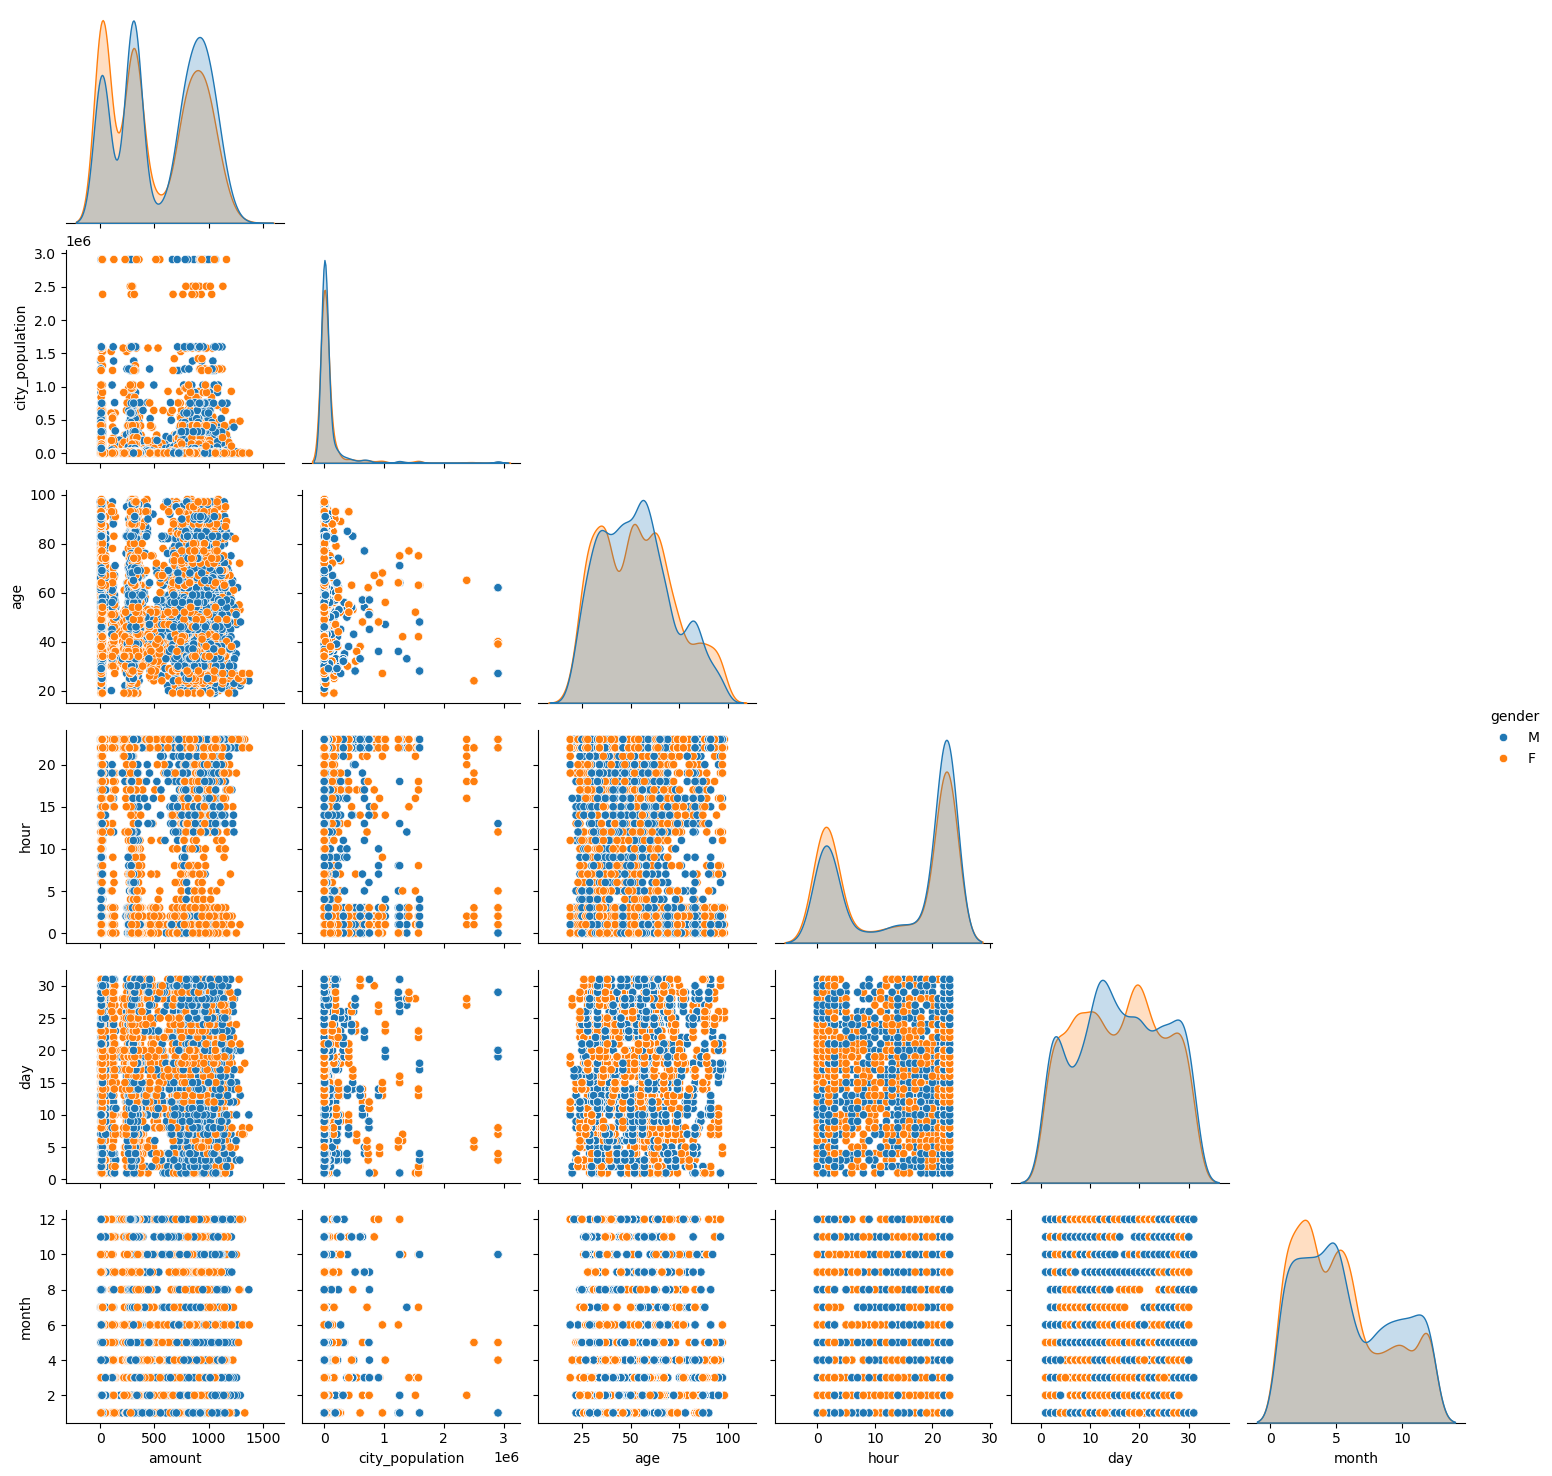

In [199]:
pairplot = sns.pairplot(eda_correlation, hue='gender', corner=True)
pairplot.savefig(FIG_DIR / 'fraud_pairplot.png')
pairplot;

In [200]:
def bar_value(ax):
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

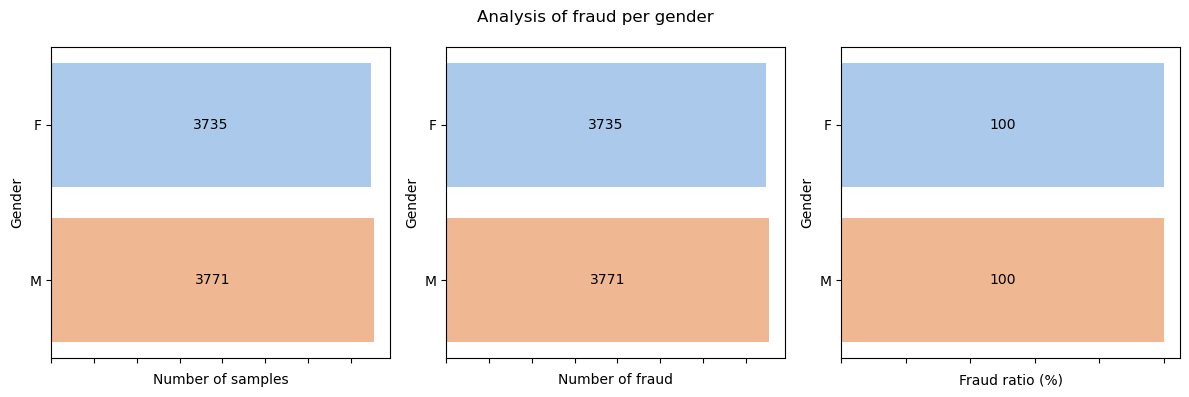

In [201]:
df_gender_is_fraud = fraud_df[['gender', 'is_fraud']]
df_gender_is_fraud = df_gender_is_fraud.groupby(['gender']).agg(['count', 'sum', 'mean'])
df_gender_is_fraud.columns = ['count', 'fraud_number', 'fraud_ratio']
df_gender_is_fraud.reset_index(inplace=True)
df_gender_is_fraud["fraud_ratio"] = df_gender_is_fraud["fraud_ratio"].apply(lambda x: round(x*100, 2))

fig, ax = plt.subplots(1,3, figsize=(12,4))

sns.barplot(
    data=df_gender_is_fraud,
    x='count',
    y='gender',
    orient='h',
    hue='gender',
    palette='pastel',
    ax=ax[0]
)
bar_value(ax[0])

ax[0].set_ylabel('Gender')
ax[0].set_xlabel('Number of samples')
ax[0].set_xticklabels([])

sns.barplot(
    data=df_gender_is_fraud,
    x='fraud_number',
    y='gender',
    orient='h',
    hue='gender',
    palette='pastel',
    ax=ax[1]
)
bar_value(ax[1])

ax[1].set_ylabel('Gender')
ax[1].set_xlabel('Number of fraud')
ax[1].set_xticklabels([])

sns.barplot(
    data=df_gender_is_fraud,
    x='fraud_ratio',
    y='gender',
    orient='h',
    hue='gender',
    palette='pastel',
    ax=ax[2]
)
bar_value(ax[2])

ax[2].set_ylabel('Gender')
ax[2].set_xlabel('Fraud ratio (%)')
ax[2].set_xticklabels([])

fig.suptitle("Analysis of fraud per gender")
fig.savefig(FIG_DIR / 'Analysis_of_fraud_per_gender.png')
fig.tight_layout();

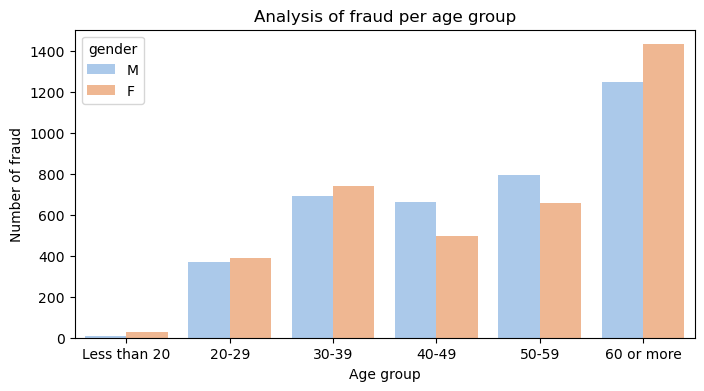

In [202]:
order = ['Less than 20', '20-29', '30-39', '40-49', '50-59', '60 or more']

fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(
    data=fraud_df,
    x='age_group',
    hue='gender',
    palette='pastel',
    order=order,
    ax=ax 
)
ax.set_title('Analysis of fraud per age group')
ax.set_xlabel('Age group')
ax.set_ylabel('Number of fraud')

fig.savefig(FIG_DIR / 'Analysis_of_fraud_per_age_group.png');

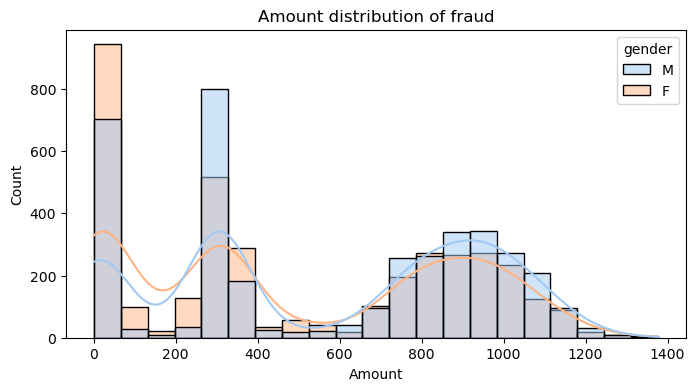

In [203]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.histplot(
    data=fraud_df,
    x='amount',
    kde=True,
    hue='gender',
    palette='pastel',
    ax=ax
)

ax.set_title('Amount distribution of fraud')
ax.set_xlabel('Amount')

fig.savefig(FIG_DIR / 'Amount_distribution_of_fraud.png');

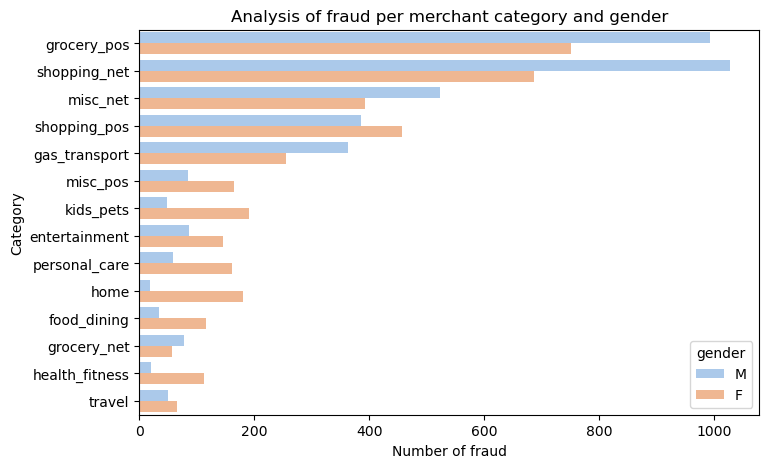

In [204]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.countplot(
    data=fraud_df,
    y='merchant_category',
    hue='gender',
    orient='h',
    palette='pastel',
    order=fraud_df['merchant_category'].value_counts().index,
)

ax.set_title('Analysis of fraud per merchant category and gender')
ax.set_ylabel('Category')
ax.set_xlabel('Number of fraud')

fig.savefig(FIG_DIR / 'Analysis_of_fraud_per_merchant_category.png');

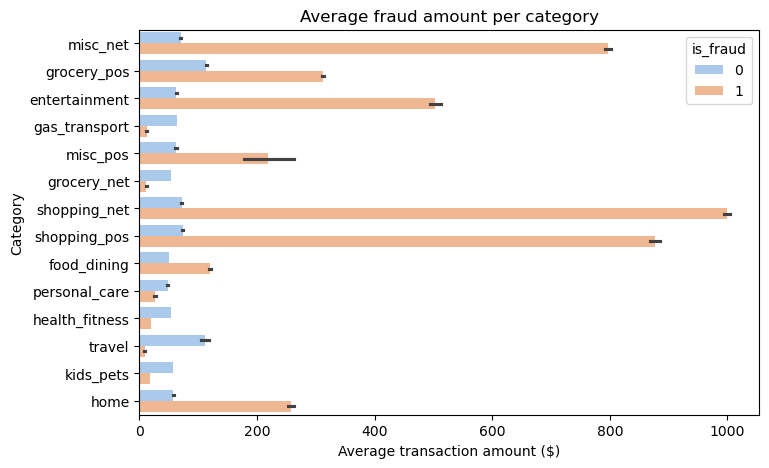

In [205]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(
    data=fraud_train,
    x='amt',
    y='category',
    hue='is_fraud',
    orient='h',
    palette='pastel',
)

ax.set_title('Average fraud amount per category')
ax.set_ylabel('Category')
ax.set_xlabel('Average transaction amount ($)')

fig.savefig(FIG_DIR / 'Average_fraud_amount_per_category.png');

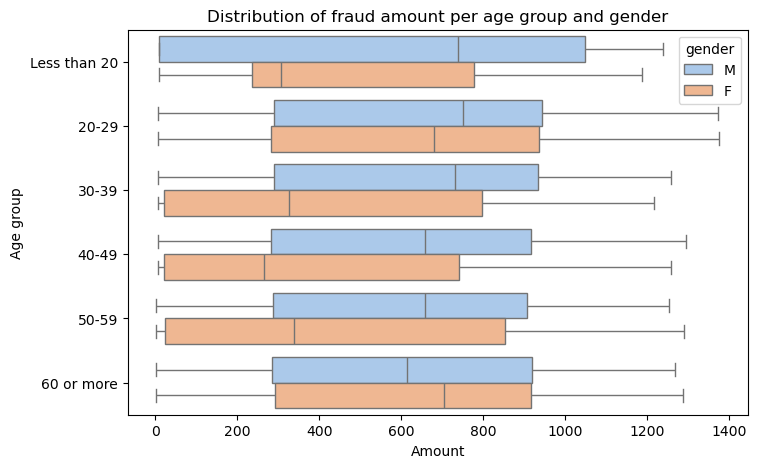

In [206]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(
    data=fraud_df,
    x='amount',
    y='age_group',
    hue='gender',
    orient='h',
    order=order,
    palette='pastel'
)

ax.set_title('Distribution of fraud amount per age group and gender')
ax.set_xlabel('Amount')
ax.set_ylabel('Age group')

fig.savefig(FIG_DIR / 'Distribution_of_fraud_amount_per_age.png');

In [207]:
fraud_dist_per_state = fraud_df.groupby(['state']).agg({'is_fraud': 'sum'}).reset_index().sort_values(by='state')

with open(DATA_DIR / 'state_dict.pkl', 'rb') as f:
    state_dict = pkl.load(f)


fig = go.Figure(data=go.Choropleth(
    locations=fraud_dist_per_state['state'], # Spatial coordinates
    z = fraud_dist_per_state['is_fraud'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=fraud_dist_per_state['state'].map(state_dict),
    marker_line_color='white', # line markers between states
    colorbar_title = "Fraud transactions",
))

fig.update_layout(
    title_text = 'Number of fraud transactions per state',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.write_html(FIG_DIR / 'Number_of_fraud_transactions_per_state.html')

fig.show()

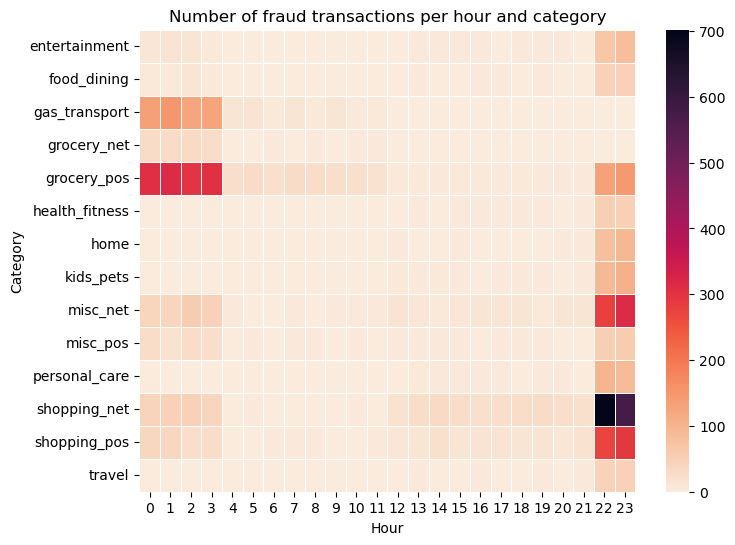

In [208]:
crosstab_hour_cat = pd.crosstab(fraud_df["merchant_category"], fraud_df["hour"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(crosstab_hour_cat, cmap='rocket_r', linewidths=0.5, ax=ax)

ax.set_title('Number of fraud transactions per hour and category')
ax.set_xlabel('Hour')
ax.set_ylabel('Category')

fig.savefig(FIG_DIR / 'Number_of_fraud_transactions_per_hour_and_category.png');

In [228]:
sf_map = folium.Map(
    location=[39.516334, -99.591048],
    zoom_start=4.2,
    tiles="OpenStreetMap",
)

fraud_merchants = plugins.MarkerCluster()

for lat, lon, name in zip(
    fraud_df["merch_lat"],
    fraud_df["merch_long"],
    fraud_df["merchant_name"],
):

    fraud_merchants.add_child(folium.Marker(location=[lat, lon], popup=name))

sf_map.add_child(fraud_merchants)

with open(DATA_DIR / "us-states.json", "r") as geojson_file:
    us_states = json.load(geojson_file)

folium.Choropleth(
    geo_data=us_states,
    data=fraud_dist_per_state,
    columns=[fraud_dist_per_state['state'].map(state_dict), "is_fraud"],
    key_on="feature.properties.name",
    fill_color='OrRd'
).add_to(sf_map)

sf_map

### Preprocessing

In [ ]:
fraud_processed = fraud_train.copy()

In [ ]:
# Las columna trans_date_trans_time indica la fecha de la transaccion, 

fraud_processed.drop(columns=['cc_num', 'first', 'last', 'street', 'trans_num', 'zip'], inplace=True)

In [ ]:
fraud_processed.info()

In [ ]:
fraud_processed["unix_time"] = fraud_processed["unix_time"].apply(
    lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")
)

In [ ]:
fraud_processed.head()

La columna `unix_time` contiene la misma información que la columna `trans_date_trans_time` pero con el año erróneo, ya que los datos empiezan en el 1 de enero de 2019 mientras que la columna `unix_time` empieza en el año 2012.

In [ ]:
fraud_processed['trans_date_trans_time'] = pd.to_datetime(fraud_processed['trans_date_trans_time'])

fraud_processed['trans_date'] = fraud_processed['trans_date_trans_time'].dt.date
fraud_processed['trans_time'] = fraud_processed['trans_date_trans_time'].dt.time

fraud_processed['hour'] = fraud_processed['trans_time'].apply(lambda x: x.hour)
fraud_processed['day'] = fraud_processed['trans_date'].apply(lambda x: x.day)
fraud_processed['month'] = fraud_processed['trans_date'].apply(lambda x: x.month)

fraud_processed.drop(columns=['unix_time', 'trans_date_trans_time'], inplace=True)

In [ ]:
fraud_processed.head()

NameError: name 'fraud_processed' is not defined

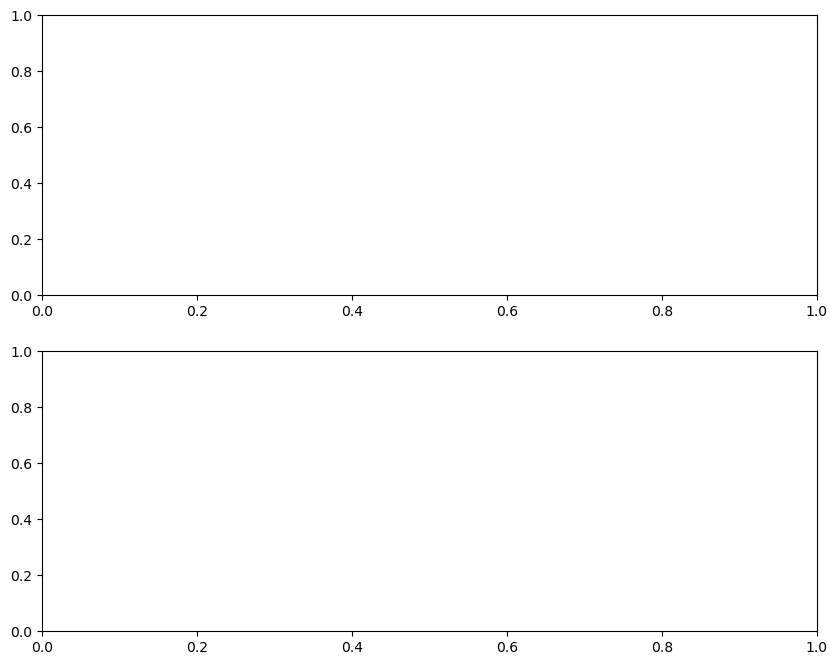

In [171]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].hist(fraud_processed['hour'], bins=24, edgecolor='black')

ax[0].hist(fraud_processed[fraud_processed['is_fraud'] == 1]['hour'], bins=24, edgecolor='black')
ax[1].hist(fraud_processed[fraud_processed['is_fraud'] == 1]['hour'], bins=24, edgecolor='black', color='orange');

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].hist(fraud_processed['day'], bins=31, edgecolor='black')
ax[1].hist(fraud_processed[fraud_processed['is_fraud'] == 1]['day'], bins=31, edgecolor='black', color='orange');


In [ ]:
fraud_processed['dob'] = pd.to_datetime(fraud_processed['dob']).apply(lambda x: (datetime.now() - x).days // 365)
fraud_processed.rename(columns={'dob': 'age'}, inplace=True)

In [ ]:
fraud_processed.head()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sns.histplot(fraud_processed['age'], bins=20, edgecolor='black', ax=ax[0], kde=True)
sns.histplot(fraud_processed[fraud_processed['is_fraud'] == 1]['age'], bins=20, edgecolor='black', color='orange', ax=ax[1], kde=True);

In [ ]:
fraud_processed['is_fraud'].value_counts() / fraud_processed.shape[0]

In [ ]:
is_fraud_sample = fraud_processed[fraud_processed['is_fraud'] == 0].sample(n=8000, random_state=314)


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(is_fraud_sample['amt'], bins=100, edgecolor='black', ax=ax[0])
ax[0].set_xlim(0, 1500)

sns.histplot(fraud_processed[fraud_processed['is_fraud'] == 1]['amt'], bins=100, edgecolor='black', ax=ax[1], kde=True, color='orange');

In [ ]:
gender_dummies = pd.get_dummies(fraud_processed['gender'], prefix='gender')
fraud_processed = pd.concat([fraud_processed, gender_dummies], axis=1)#.drop(columns='gender')

fraud_processed.head()